In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
data=pd.read_csv("../levelups_panel_20240717.csv", encoding="utf-8")

In [162]:
# level_to 컬럼의 값이 100을 넘는 행 제거
data = data[data['level_to'] <= 100]
data = data[data['highest_level'] >= 100]
data['binge'] = (data['first_session_level'] >= 50).astype(int)
# 각 player_slug별로 비율 계산
data['prev_interval'] = data.groupby('player_slug')['interval'].shift(1)
data['interval_ratio'] = data.apply(lambda row: row['interval'] / (row['prev_interval'] if pd.notnull(row['prev_interval']) else row['interval']), axis=1)
#data.to_csv("LV100.csv",index=False, encoding="utf-8")


In [163]:
data[data['player_slug']=='2022-03-08T06:59:00.410Z']

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge,prev_interval,interval_ratio
1908299,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,1,2,...,0.0,0.0,0.0,2022-03-10,2022-03-10,True,10.578333,1,NaN,1.000000
1908300,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,2,3,...,0.0,0.0,0.0,2022-03-10,2022-03-10,True,10.578333,1,0.010833,0.410256
1908301,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,3,4,...,0.0,0.0,0.0,2022-03-10,2022-03-10,True,10.578333,1,0.004444,1.750000
1908302,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,4,5,...,0.0,0.0,0.0,2022-03-10,2022-03-10,True,10.578333,1,0.007778,1.500000
1908303,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,5,6,...,0.0,0.0,0.0,2022-03-10,2022-03-10,True,10.578333,1,0.011667,1.214286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908393,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,95,96,...,0.0,0.0,0.0,2022-03-10,2022-03-10,True,10.578333,1,0.054722,0.035533
1908394,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,96,97,...,0.0,0.0,0.0,2022-03-10,2022-03-10,True,10.578333,1,0.001944,1.000000
1908395,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,97,98,...,0.0,0.0,0.0,2022-03-10,2022-03-10,True,10.578333,1,0.001944,56.857143
1908396,2022-03-08T06:59:00.410Z,야롯,101,1,0.0,2.0,111,complete,98,99,...,0.0,0.0,0.0,2022-03-10,2022-03-10,True,10.578333,1,0.110556,0.773869


In [164]:
#Remove odd ratio data
# 각 level_to 그룹별로 interval의 평균 계산
lev_avg = data.groupby('level_to')['interval'].median()
lev_avg_dict = lev_avg.to_dict()

data['interval'] = data.apply(
    lambda row: np.nan if (row['interval_ratio'] > 10 and row['interval'] > 50 * lev_avg_dict[row['level_to']]) else row['interval'], 
    axis=1
)
# Step 2: player_slug가 동일하고 바로 다음 행에서 interval_ratio가 1인 데이터 처리

for i in range(len(data) - 1):
    if data.iloc[i]['interval_ratio'] > 50 and data.iloc[i]['player_slug'] == data.iloc[i + 1]['player_slug'] and data.iloc[i + 1]['interval_ratio'] >= 0.1 and pd.isna(data.iloc[i]['interval']):
        data.iloc[i + 1, data.columns.get_loc('interval')] = np.nan


data_ratio_term = data[['player_slug','binge', 'level_to', 'interval']]
threshold_df = pd.DataFrame(columns=['Column', 'Threshold'])

# 데이터 피벗
pivot_data_ratio = data_ratio_term.pivot_table(index='player_slug', columns='level_to', values='interval', aggfunc='mean')
binge_series = data.drop_duplicates('player_slug').set_index('player_slug')['binge']
pivot_data_ratio = pivot_data_ratio.join(binge_series)
#Remove top 1% value of the interval
columns_to_exclude = ['binge']
for column in pivot_data_ratio.columns:
    # NaN 값을 제외하고 상위 99% 값 계산
    threshold = pivot_data_ratio[column].dropna().quantile(0.975)
    
    pivot_data_ratio.loc[pivot_data_ratio[column] > threshold, column] = np.nan
    # 컬럼명과 threshold 값을 데이터프레임에 추가
    temp_df = pd.DataFrame({'Column': [column], 'Threshold': [threshold]})
    
    # 기존 데이터프레임과 임시 데이터프레임을 결합
    threshold_df = pd.concat([threshold_df, temp_df], ignore_index=True)

pivot_data_reset = pivot_data_ratio.reset_index().melt(id_vars=['player_slug', 'binge'], var_name='level_to', value_name='interval')


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_6944\4232688477.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  threshold_df = pd.concat([threshold_df, temp_df], ignore_index=True)


In [165]:
threshold_df

,Column,Threshold
0,2,0.194194
1,3,0.036486
2,4,0.056667
3,5,0.057340
4,6,0.111903
...,...,...
95,97,0.815944
96,98,0.850556
97,99,2.134972
98,100,3.387417


In [166]:
pivot_data_reset['interval'].max()
max_interval_index = pivot_data_reset['interval'].idxmax()
max_interval_row = pivot_data_reset.loc[max_interval_index]
max_interval_row

player_slug    2021-12-18T08:11:41.472Z
binge                               1.0
level_to                            100
interval                       3.384167
Name: 713988, dtype: object

In [167]:
k=data[data['player_slug']=='2022-01-27T00:00:16.270Z']
k[['level_to','interval','interval_ratio']]

,level_to,interval,interval_ratio
1440969,2,0.016944,1.000000
1440970,3,0.010278,0.606557
1440971,4,0.015278,1.486486
1440972,5,0.023611,1.545455
1440973,6,0.026389,1.117647
...,...,...,...
1441063,96,0.896111,1.041317
1441064,97,0.956111,1.066956
1441065,98,0.981389,1.026438
1441066,99,1.028889,1.048401


In [168]:
check=data[data['level_to']==100]
# 'value' 컬럼에서 최댓값 찾기
max_value = check['interval'].median()
max_value

0.1188888888888888

In [169]:
lev_avg = data.groupby('level_to')['interval'].mean()
lev_avg


level_to
2      0.535849
3      0.013721
4      0.027087
5      0.038660
6      0.033977
         ...   
96     0.176121
97     0.131002
98     0.158183
99     0.287864
100    0.435689
Name: interval, Length: 99, dtype: float64

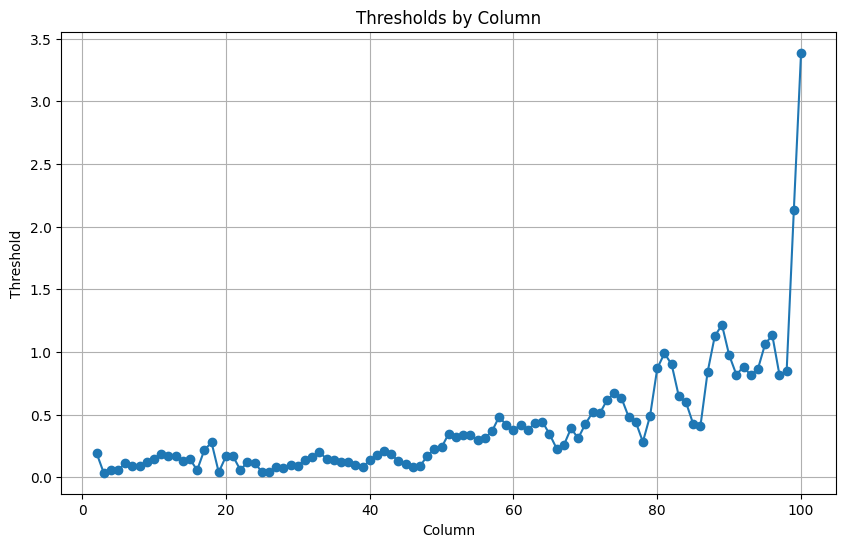

In [170]:
# 마지막 행 드랍
df = threshold_df.drop(threshold_df.index[-1])

# 플롯 그리기
plt.figure(figsize=(10, 6))
plt.plot(df['Column'], df['Threshold'], marker='o')
plt.xlabel('Column')
plt.ylabel('Threshold')
plt.title('Thresholds by Column')
plt.grid(True)
plt.show()

In [171]:
pivot_data_ratio.to_csv('remove_outlier_0919.csv',encoding='utf-8')

In [172]:
import numpy as np
import pandas as pd
import cvxpy as cp
from tqdm import tqdm
#pivot_data_ratio =pd.read_csv("Before_Synthetic.csv",encoding='utf-8')
pivot_data_ratio =pd.read_csv("remove_outlier_0919.csv",encoding='utf-8')
origin_data=pd.read_csv("../levelups_panel_20240717.csv",encoding='utf-8')
origin_data = origin_data[origin_data['level_to'] <= 100]
origin_data = origin_data[origin_data['highest_level'] >= 100]

In [173]:
# other_data를 before_synthetic에 병합
for i, row in tqdm(origin_data.iterrows(), total=origin_data.shape[0]):
    player = row['player_slug']
    level_to = str(row['level_to'])
    if player in pivot_data_ratio['player_slug'].values and level_to in pivot_data_ratio.columns:
        origin_data.loc[i, 'interval'] = pivot_data_ratio.loc[pivot_data_ratio['player_slug'] == player, level_to].values[0]


100%|██████████| 720621/720621 [10:24<00:00, 1153.46it/s]


In [174]:
origin_data.to_csv("levelups_panel_20240919_new.csv", index=False,encoding="utf-8")
origin_data.to_csv("levelups_panel_20240919_newcp949.csv", index=False,encoding="cp949")

In [177]:
data=pd.read_csv("levelups_panel_20240919_new.csv",encoding="utf-8")

In [178]:
print(data['interval'].isna().sum())


33020


In [179]:
data['interval'].max()
max_interval_index = data['interval'].idxmax()
max_interval_row = data.loc[max_interval_index]
max_interval_row

player_slug            2021-12-18T08:11:41.472Z
character_slug                              재쭈니
first_session_level                         103
binger                                        1
total_purchase                           3300.0
total_ad                                    2.0
highest_level                               103
status                                 complete
level_from                                   99
level_to                                    100
event_datetime              2021-12-19 00:27:32
death                                       2.0
ad_revival                                  1.0
ad_item                                     0.0
ad_total                                    1.0
purchase                                    0.0
event_datetime_prev         2021-12-18 21:04:30
interval                               3.384167
interval_cum                           7.276389
playtime_boss                               0.0
playtime_dungeon                        

In [180]:
check=data[data['player_slug']=='2022-03-08T06:59:00.410Z']
check[['level_to','interval']]

,level_to,interval
507771,2,0.010833
507772,3,0.004444
507773,4,0.007778
507774,5,0.011667
507775,6,0.014167
...,...,...
507865,96,0.001944
507866,97,0.001944
507867,98,0.110556
507868,99,0.085556


In [181]:
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import minimize
import warnings

# 경고 메시지 억제
warnings.filterwarnings("ignore", message="X does not have valid feature names, but NearestNeighbors was fitted with feature names")

def fill_missing_intervals(data,k=5):
    complete_data = data.dropna(subset=['interval'])
    missing_data = data[data['interval'].isnull()]
    
    # level_from과 level_to 외의 다른 feature들을 추가
    features = ['level_to','death','playtime_side','ad_revival','purchase','highest_level','ad_item']
    
    knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
    knn.fit(complete_data[features])

    for index, row in tqdm(missing_data.iterrows(), total=missing_data.shape[0], desc="Filling missing intervals"):
        # feature 값을 2차원 배열로 변환하여 전달
        distances, indices = knn.kneighbors([row[features].values])
        neighbor_intervals = complete_data.iloc[indices[0]]['interval']
        predicted_interval = np.mean(neighbor_intervals)
        
        data.at[index, 'interval'] = predicted_interval
    
    return data

data_filled = fill_missing_intervals(data)


Filling missing intervals: 100%|██████████| 33020/33020 [00:16<00:00, 1945.13it/s]


In [182]:
output_file_path = 'levelups_panel_0920_filled.csv'
data_filled.to_csv(output_file_path, index=False,encoding='utf-8')

In [30]:
data

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge,prev_interval,interval_ratio
108,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,1,2,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1,NaN,1.000000
109,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,2,3,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1,1.731389,0.002407
110,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,3,4,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1,0.004167,2.266667
111,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,4,5,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1,0.009444,1.676471
112,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,5,6,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1,0.015833,0.964912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466396,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,95,96,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,1,0.059444,0.098131
2466397,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,96,97,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,1,0.005833,0.523810
2466398,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,97,98,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,1,0.003056,15.545455
2466399,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,98,99,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,1,0.047500,1.520468


In [34]:
check=focal_data[focal_data['player_slug']=='2021-11-04T21:02:14.418Z']
check[['level_from','level_to','interval']]

,level_from,level_to,interval
12988,1,2,0.010833
12989,2,3,0.003056
12990,3,4,0.005833
12991,4,5,0.073611
12992,5,6,0.013611
12993,6,7,0.019444
12994,7,8,0.023056
12995,8,9,0.026944
12996,9,10,0.031667
12997,10,11,0.046111


In [18]:
check=data[data['player_slug']=='2022-03-09T10:40:35.069Z']
check[['level_from','level_to','interval','interval_ratio']].tail(20)

KeyError: "['level_from', 'interval_ratio'] not in index"